# Obecná audio podobnost

## MFCC deskriptor

In [78]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from dtw import dtw
from numpy.linalg import norm

In [79]:
y1, sr1 = librosa.load('data/sample_1.wav')
y2, sr2 = librosa.load('data/dubstep_beat_1.wav')
y3, sr3 = librosa.load('data/dubstep_drum.mp3')

/Users/jstorm31/Dev/Python/mvv-project/env/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


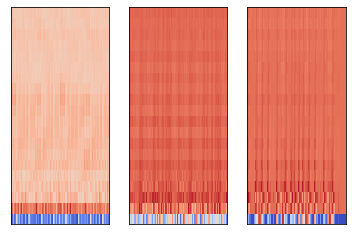

In [80]:
#Showing multiple plots using subplot
plt.subplot(1, 3, 1) 
mfcc1 = librosa.feature.mfcc(y1,sr1)   #Computing MFCC values
librosa.display.specshow(mfcc1)

plt.subplot(1, 3, 2)
mfcc2 = librosa.feature.mfcc(y2, sr2)
librosa.display.specshow(mfcc2)

plt.subplot(1, 3, 3)
mfcc3 = librosa.feature.mfcc(y3, sr3)
librosa.display.specshow(mfcc3)

In [31]:
dist, cost, acc_cost, path = dtw(mfcc1.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
print('Normalized distance between the two sounds:', dist)

Normalized distance between the two sounds: 267284.28454589844


In [36]:
dist, cost, acc_cost, path = dtw(mfcc3.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
print('Normalized distance between the two sounds:', dist)

Normalized distance between the two sounds: 195374.9662246704


## Fingerprinting

In [1]:
import acoustid

In [9]:
duration1, fingerprint1 = acoustid.fingerprint_file('data/dubstep_beat_1.wav')

In [10]:
duration2, fingerprint2 = acoustid.fingerprint_file('data/dubstep_drum.mp3')

In [65]:
popcnt_table_8bit = [
    0,1,1,2,1,2,2,3,1,2,2,3,2,3,3,4,1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,
    1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
    1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
    2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
    1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
    2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
    2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
    3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,4,5,5,6,5,6,6,7,5,6,6,7,6,7,7,8,
]

def popcnt(x):
    """
    Count the number of set bits in the given 32-bit integer.
    """
    return (popcnt_table_8bit[(x >>  0) & 0xFF] +
            popcnt_table_8bit[(x >>  8) & 0xFF] +
            popcnt_table_8bit[(x >> 16) & 0xFF] +
            popcnt_table_8bit[(x >> 24) & 0xFF])

In [72]:
def compare_fingerprints(fp1, fp2):
    error = 0
    for x, y in zip(fp1, fp2):
        error += popcnt(x ^ y)
    print(1.0 - error / 32.0 / min(len(fp1), len(fp2)))

In [31]:
fingerprint1

b'AQAAWcqWLNkiI0-I5lkOHcWz482MH9CHHz9SPSu-4zv6w04WBMcvnKic8XhzHGiO7sHhmEF_OEcf5WjOEF0z9IGWmEEfiGdwHCeOR5SI74F9aFfwRfh4OE2WFW-KH3qI53hyIc07HLl0MGGUBRJ-VMGp4zTu44Tw7BIqXQiTvPjwBw2XBTl69MePyjne_MDRH40e42jyoM-KJke_HM0X9FkIAhAEBiAoGAKQAIAMIlQxJoSQiDgikCAACeCQAwApYoBwiClPFFAIIUEJEAopRogySCmoAGQKCAGkAsQZYYgAAg'

In [82]:
fpcalc_out="FINGERPRINT=1097131814,1097099559,1365727511,1365661973,1365661957,1366711749,1364641157,1398194565,1398194565,1398199175,1406583687,1408680903,1374012262,1373946150,1365566758,1348756790,1348951318,1348951319,1348885783,1432769815,1432831255,1165391175,1163281863,1163314631,1163314631,1163380215,1163183463,1163191655,1163392263,1165481239,1165350263,1198810471,1196914007,1196836295,1196934615,1196742053,1196746165,1196946839,1196938647,1196937623,1196814743,1196814807,1199002391,1098348311,1097301815,1097088805,1097083237,1365536229,1400329605,1398198661,1381417349,1138147719,1140245127,1135002439,1105511206,1105512230,1097101095,1097292063,1097292053,1130780949,1130781125,1131826565,1129760133,1398260101,1398198661,1398198663,1375126151,1369883607,1373946662,1373955878,1348792102,1348984086,1348951319,1348885767,1415992599,1432765719,1433826631,1163281863,1163281863,1163314631,1171768791,1163183463,1163191655,1163388183,1165415687,1165481335,1198847335,1198875991,1196840263"
fpcalc_out2="FINGERPRINT=1699902959,1701988079,1710444271,1706118879,1706098375,1708191303,1741745935,1733422367,1733424159,1733555231,1733554207,1729319039,1729196287,1697870335,1702000623,1710378735,1710444287,1706127071,1706094287,1708191311,1708191503,1733424415,1733424191,1733424191,1733554239,1729359999,1695764735,1695774207,1702000623,1710378735,1710444271,1706151639,1710288455,1708191303,1741745935,1733424415,1733424191"

In [83]:
fingerprint_index = fpcalc_out.find('FINGERPRINT=') + 12

In [84]:
fp1 = list(map(int, fpcalc_out[fingerprint_index:].split(',')))
fp2 = list(map(int, fpcalc_out2[fingerprint_index:].split(',')))

In [85]:
compare_fingerprints(fp1, fp2)

0.5793918918918919


### Otázky
 - Jak kombinovat více deskriptorů?
 - Co s různou délkou souborů? Co když je nahrávka uprostřed toho druhého songu?
 - Co s výkonností u porovnávání deskriptorů?
